<a href="https://colab.research.google.com/github/tornikeo/lut-gpgpu-course/blob/main/gpgpu_e2_tornikeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import ceil as roof
import numba
from numba import cuda
import numpy as np
from numba import types
assert cuda.is_available()

## Task 1:

a) Implement a kernel which takes two vectors A and B and adds them together to form a vector C.

In [3]:
np.random.seed(42)
size = int(1e6)

# inp = np.random.uniform(size=size)
inp = np.arange(size).astype('float32')
out = np.empty_like(inp)
out[-1] = 0
inp_cu = cuda.to_device(inp)
out_cu = cuda.device_array_like(out)

@cuda.jit
def kernel_v1(inp, out):
    gx = cuda.grid(1)
    if gx < len(inp) - 1:
        out[gx] = inp[gx + 1] - inp[gx]

THREADS_PER_BLOCK = (1024,1,1)
BLOCKS_PER_GRID = (roof(len(inp) / (THREADS_PER_BLOCK[0] - 1)), 1, 1)
        
@cuda.jit
def kernel_v2(inp, out):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    
    gx = cuda.grid(1)
    sh = cuda.shared.array(THREADS_PER_BLOCK[0], numba.types.float32)

    if gx - bx < len(inp):
        sh[tx] = inp[gx - bx]
    
    cuda.syncthreads()
    
    if gx - bx < len(inp) and tx + 1 < len(sh):
        out[gx - bx] = sh[tx + 1] - sh[tx]


kernel_v2[BLOCKS_PER_GRID, THREADS_PER_BLOCK](inp_cu, out_cu)

out_cu.copy_to_host(out)

y_true = np.diff(inp)
y_pred = out[:-1]

print(inp)
print(y_true)
print(y_pred)

np.allclose(y_true, y_pred)

[0.00000e+00 1.00000e+00 2.00000e+00 ... 9.99997e+05 9.99998e+05
 9.99999e+05]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]


True

## Task 2:

Implement the three reduction models presented in the lectures. Time their performance against different vector sizes. Execution times can vary between executions, so run them for example 100 times and take the average time.

Use for example $2^{10}$, $2^{13}$, $2^{16}$, $2^{20}$, and $2^{22}$ values and plot them into same graph.

Add also CPU performance with numpy sum() - function.

Sequential reduction

In [4]:
# Sequential
size = int(1e8)
inp = np.ones(size,'float32')
inp_cu = cuda.to_device(inp)

@cuda.jit
def kernel_sequential(inp: np.ndarray, 
                      stride: int):
    gx = cuda.grid(1)
    if (gx % (stride * 2)) == 0 and gx + stride < len(inp):
        inp[gx] += inp[gx + stride]
    

THREADS_PER_BLOCK = (1024,1,1)
BLOCKS_PER_GRID = (roof(len(inp) / THREADS_PER_BLOCK[0]), 1, 1)

stride = 1

while stride < len(inp):
    kernel_sequential[BLOCKS_PER_GRID, THREADS_PER_BLOCK](inp_cu, stride)
    stride *= 2

out = inp_cu.copy_to_host()

y_true = np.sum(inp)
y_pred = out[0]

# print(inp)
print(y_true)
print(y_pred)

# np.allclose(y_true, y_pred)

100000000.0
100000000.0


In [7]:
# Shared mem + sequential
np.random.seed(42)
size = int(2 ** 22)
inp = np.random.uniform(size=size).astype('float32')
inp_cu = cuda.to_device(inp)


THREADS_PER_BLOCK = (1024,1,1)

@cuda.jit
def kernel_sequential_shared(
        inp: np.ndarray,
        size: int,
    ):
    gx = cuda.grid(1)
    tx = cuda.threadIdx.x
    sh = cuda.shared.array(THREADS_PER_BLOCK[0], types.float32)
    
    if gx < size:
        sh[tx] = inp[gx]
    else:
        sh[tx] = 0
    
    cuda.syncthreads()
    
    stride = 1
    while True:
        if not (stride < cuda.blockDim.x):
            break
        
        if tx % (stride * 2) == 0 and tx + stride < len(sh):
            sh[tx] += sh[tx + stride]
        cuda.syncthreads()  
        
        stride *= 2        
    
    if tx == 0:
        inp[cuda.blockIdx.x] = sh[0]
    
BLOCKS_PER_GRID = (roof(len(inp) / THREADS_PER_BLOCK[0]), 1, 1)

size_iter = len(inp)
while size_iter > 1:
    kernel_sequential_shared[BLOCKS_PER_GRID, THREADS_PER_BLOCK](inp_cu, size_iter)
    size_iter = roof(size_iter / THREADS_PER_BLOCK[0])

out = inp_cu.copy_to_host()
y_true = np.sum(inp)
y_pred = out[0]

print(y_true)
print(y_pred)

np.allclose(y_true, y_pred)

2097089.5
2097089.4


True

100%|██████████| 16/16 [00:01<00:00, 15.40it/s] 
16it [00:11,  1.36it/s]
16it [00:03,  4.49it/s]


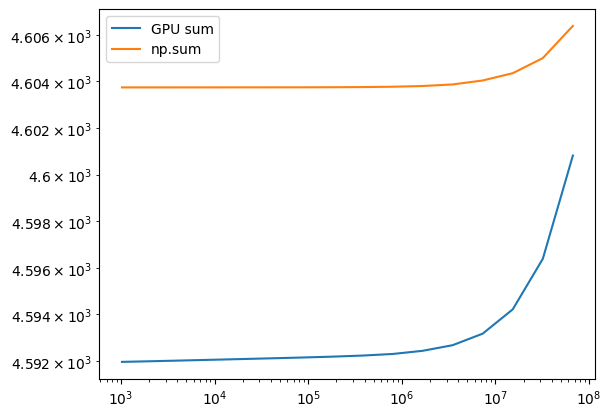

In [5]:
import matplotlib.pyplot as plt
from time import  perf_counter
from tqdm import tqdm


sizes = np.logspace(10, 26, num=16, base=2).astype('int32')
inputs = []


for size in tqdm(sizes):
    size = int(size)
    inp = np.random.uniform(size=size).astype('float32')
    inputs.append(inp)
mean_times = []


for i, size in tqdm(enumerate(sizes)):
    size = int(size)
    times = []
    inp = inputs[i]
    for _ in range(100):
        inp_cu = cuda.to_device(inp)
        size_iter = len(inp)
        BLOCKS_PER_GRID = (roof(len(inp) / THREADS_PER_BLOCK[0]), 1, 1)
        while size_iter > 1:
            duration = -perf_counter()
            kernel_sequential_shared[BLOCKS_PER_GRID, THREADS_PER_BLOCK](inp_cu, size_iter)
            duration = +perf_counter()
            size_iter = roof(size_iter / THREADS_PER_BLOCK[0])
        times.append(duration)
    
    mean_times.append(np.mean(times))
    
plt.loglog(sizes, mean_times, label='GPU sum')

vals = [] # This is to make sure numpy *does* compute results
mean_times = []
for i, size in tqdm(enumerate(sizes)):
    size = int(size)
    times = []
    inp = inputs[i]
    for _ in range(100):
        duration = -perf_counter()
        vals.append(inp.sum())
        duration = +perf_counter()
        times.append(duration)
    
    mean_times.append(np.mean(times))
    
    
plt.loglog(sizes, mean_times, label='np.sum')
plt.xlabel("Array size")
plt.ylabel("wall-clock time (ms)")
plt.legend()
plt.show()

## Task 3:

Extend the kernel from task 2 to use shared memory.